In [33]:
import pandas as pd
import numpy as np
import os
import random
from copy import deepcopy
import math
from itertools import product
import pickle
import joblib

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

In [23]:
# user_df = pd.read_csv('./data/user_spec.csv')
loan_df = pd.read_csv('./data/loan_result.csv')
# log_df = pd.read_csv('./data/log_data.csv' )

In [40]:
random_list = [ random.randint(1,1000) for i in range(5)]
random_list

[672, 668, 254, 413, 923]

# loan_df 전처리

In [24]:
loan_df.shape

(13527363, 7)

In [25]:
loan_df['is_applied'].dropna(axis=0).index

Int64Index([   13284,    13285,    13286,    13287,    13288,    13289,
               13290,    13291,    13292,    13293,
            ...
            13519629, 13519630, 13519631, 13519632, 13519633, 13519634,
            13519635, 13519636, 13519637, 13519638],
           dtype='int64', length=10270124)

In [26]:
loan_df = loan_df.loc[loan_df['is_applied'].dropna(axis=0).index]
loan_df.drop(['loanapply_insert_time'], axis=1, inplace=True)

In [41]:
for mypath in ['./mydata','./model','./visual','./perf']:
    if not os.path.isdir(mypath):
        os.mkdir(mypath)

In [56]:
sum(tmp['is_applied']==0), sum(tmp['is_applied']==1)

(9709675, 560449)

# null 값 채우기

## zero fill

In [68]:
acc_list=[]
f1_list=[]
confusion_list=[]

tmp = loan_df.fillna(0)
for i, state in enumerate(random_list,1):
    data_set = pd.concat([tmp[tmp['is_applied']==0].sample(100_000, random_state=state), tmp[tmp['is_applied']==1].sample(100_000, random_state=state)])
    
    X,y= data_set.loc[:, data_set.columns !='is_applied'] ,data_set['is_applied']
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=state)
    model = RandomForestClassifier(random_state=state)
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test,y_pred))
    confusion_list.append(confusion_matrix(y_test,y_pred))
    
    with open(f'./mydata/zero_fill_index_{i}.txt','w') as f:
        f.write('\n'.join(map(str,data_set.index)))
    saved_model = pickle.dumps(model)
    
    joblib.dump(model,f'./model/zero_fill_model_{i}.pkl')
    print(i,'done')

1 done
2 done
3 done
4 done
5 done


In [71]:
print(*zip(acc_list, f1_list), sep='\n')

(0.64925, 0.6451155967015734)
(0.653375, 0.6509578833421443)
(0.652575, 0.650205139822296)
(0.6571, 0.6553768844221106)
(0.6533, 0.6513300145823905)


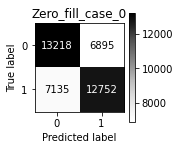

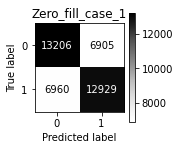

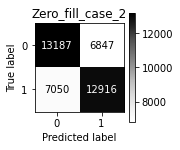

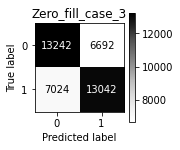

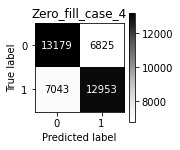

In [72]:
for i, cm in enumerate(confusion_list):
    d=ConfusionMatrixDisplay(cm,display_labels=[0,1])
    fig,ax=plt.subplots(figsize=(2,2))
    d.plot(cmap='Greys',ax=ax)
    plt.title(f'Zero_fill_case_{i}')
    plt.savefig(f'./visual/zero_fill_{i}.png')

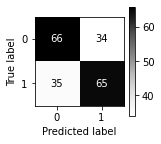

In [73]:
new_cm = np.array([cm[0]/sum(cm[0])*100, cm[1]/sum(cm[1])*100])
d=ConfusionMatrixDisplay(new_cm,display_labels=[0,1])
fig,ax=plt.subplots(figsize=(2,2))
d.plot(cmap='Greys',ax=ax)

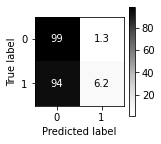

In [52]:
new_cm = np.array([cm[0]/sum(cm[0])*100, cm[1]/sum(cm[1])*100])
d=ConfusionMatrixDisplay(new_cm,display_labels=[0,1])
fig,ax=plt.subplots(figsize=(2,2))
d.plot(cmap='Greys',ax=ax)

## 함수로 돌리기

### 예제

In [80]:
a = pd.DataFrame([
    [1, np.NaN,0],
    [np.NaN,3,4],
    [0,2,np.NaN]
])
a.index = ['i1','i2','i3']
a.columns=['c1','c2','c3']

In [81]:
a

,c1,c2,c3
i1,1.0,NaN,0.0
i2,NaN,3.0,4.0
i3,0.0,2.0,NaN


In [85]:
a.mean(), a.median(), a.min(), a.max()

(c1    0.5
 c2    2.5
 c3    2.0
 dtype: float64,
 c1    0.5
 c2    2.5
 c3    2.0
 dtype: float64,
 c1    0.0
 c2    2.0
 c3    0.0
 dtype: float64,
 c1    1.0
 c2    3.0
 c3    4.0
 dtype: float64)

In [163]:
a['c1']=a['c1'].fillna(0)
a['c2']=a['c2'].fillna(0)
a

,c1,c2,c3
i1,1.0,0.0,0.0
i2,0.0,3.0,4.0
i3,0.0,2.0,NaN


In [183]:
pd.get_dummies(data = a, columns=['c1'], prefix='c1')

,c2,c3,c1_0.0,c1_1.0
i1,0.0,0.0,0,1
i2,3.0,4.0,1,0
i3,2.0,NaN,1,0


In [179]:
data_set = pd.concat([tmp[tmp['is_applied']==0].sample(100_000, random_state=random_list[i]), tmp[tmp['is_applied']==1].sample(100_000, random_state=random_list[i])])

In [187]:
data_set.drop(['bank_id','product_id'], axis=1, inplace=True)

### 돌리기

In [119]:
null_feature = ['loan_limit','loan_rate']
options = [0, 'min', 'max', 'mean', 'median']

In [120]:
list(product(options, repeat=len(null_feature)))[5]

('min', 0)

In [166]:
data_set.columns

Index(['application_id', 'bank_id', 'product_id', 'loan_limit', 'loan_rate',
       'is_applied'],
      dtype='object')

In [111]:
my_options = product(options, repeat=len(null_feature))
random_list = [ random.randint(1,1000) for i in range(len(list(my_options)))]
print(*random_list)

624 175 680 460 125 26 888 643 106 998 122 487 484 465 565 212 85 732 591 204 336 989 105 220 607


In [189]:
model_list = []
acc_list = []
f1_list = []
confusion_list = []
for i, option_group in enumerate(product(options, repeat=len(null_feature))):
    
    tmp = deepcopy(loan_df)
    
    data_set = pd.concat([tmp[tmp['is_applied']==0].sample(100_000, random_state=random_list[i]), tmp[tmp['is_applied']==1].sample(100_000, random_state=random_list[i])])
    pd.get_dummies(data = data_set, columns=['bank_id'], prefix='bank')
    pd.get_dummies(data = data_set, columns=['product_id'], prefix='product')
    data_set.drop(['bank_id','product_id'], axis=1, inplace=True)
    
    for column_name, option in zip(null_feature, list(product(options, repeat=len(null_feature)))[5]):
        if option == 0:
            data_set[column_name].fillna(0, inplace=True)
        else:
            eval(f'data_set["{column_name}"].fillna(data_set["{column_name}"].{option}(), inplace=True)')

    X,y= data_set.loc[:, data_set.columns !='is_applied'] ,data_set['is_applied']
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=random_list[i])
    model = RandomForestClassifier(random_state=random_list[i])
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    
    model_list.append(model)
    acc_list.append(model.score(X_test,y_test))
    f1_list.append(f1_score(y_test,y_pred))
    confusion_list.append(confusion_matrix(y_test,y_pred))
    
    with open(f'./mydata/{option_group[0]}_{option_group[1]}.txt','w') as f:
        f.write('\n'.join(map(str,data_set.index)))
    saved_model = pickle.dumps(model)
    joblib.dump(model,f'./model/{option_group[0]}_{option_group[1]}.pkl')
    print(i, option_group, 'done')

0 (0, 0) done


KeyboardInterrupt: 

In [ ]:
sum()